# Funcion de transferencia del sistema, sin carga
## Conjunto motor y hélice
A partir de la aproximación realizada para el motor obtenemos:
$$
\frac{0.63}{s+6.85} \frac{N}{\%}
$$

In [1]:
pkg load control

In [2]:
m = tf([0.63], [1 6.85]);

## Inercia del conjunto mecánico
La inercia del brazo mecánico esta definida por la segunda ley de Newton, es decir:
$$
\frac{1}{2.12*s^{2}} \frac{m}{N}
$$

In [3]:
a = tf([1],[2.12 0 0]);

A su vez, el peso del brazo mecánico contraresta el empuje que puede realizar el motor. Teniendo todo esto en cuenta la función de lazo abierto queda

## Setpoint y ganancia del sensor
La entrada del sistema es la altitud deseada. Puesto que es neceseario ingresar un valor de PWM entre 0 y 100 (limitación del modelo matemático que se tratará mas adelante), debemos convertir el valor de altura en un valor de PWM. Para esto se utilizarán los valores extremos que puede alcanzar el sistema, es decir, 20cm y 100% de PWM.
$$
k_i = \frac{100}{0.2} \frac{\%}{m} = 500 \frac{\%}{m} 
$$

A su vez, el sensor realimenta la diferencia de altura al motor en PWM, por lo que esta constante será tambien la ganancia del sensor ultrasónico.

$$
k_u = 500 \frac{\%}{m} 
$$

In [4]:
ki = 500;
ku = 500;
FLA=m*a
FLC=ku*feedback(FLA,ki)


Transfer function 'FLA' from input 'u1' to output ...

              0.63        
 y1:  --------------------
      2.12 s^3 + 14.52 s^2

Continuous-time model.

Transfer function 'FLC' from input 'u1' to output ...

                 315            
 y1:  --------------------------
      2.12 s^3 + 14.52 s^2 + 315

Continuous-time model.


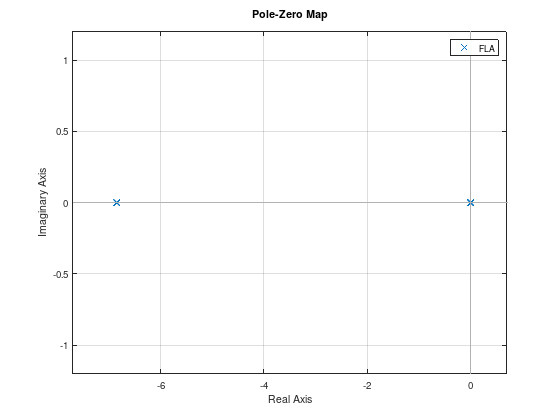

In [5]:
pzmap(FLA)

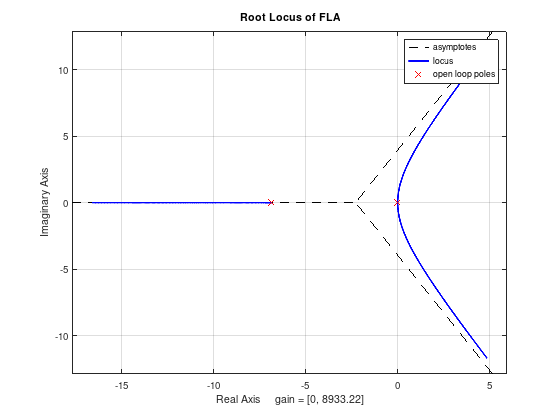

In [6]:
rlocus(FLA)

Nos encontramos con un sistema que posee dos polos en el origen. Notar que el sistema es inestable para todo valor de K en el lugar de raíces. 


Transfer function 'FLC' from input 'u1' to output ...

                 315            
 y1:  --------------------------
      2.12 s^3 + 14.52 s^2 + 315

Continuous-time model.


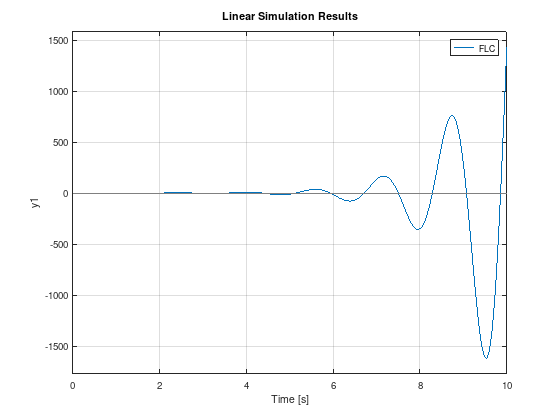

In [7]:
#Entrada del sistema
t = (0:0.01:10)';
step = 0.2*(t>=0);

FLC = ku*feedback(FLA,ku)
lsim(FLC, step, t)

Con el objetivo de lograr estabilidad, desplazamos el lugar de raices hacia la izquierda con la adicion de un cero en -0.5

$$ z_c = -1 $$
$$ C(s) = (s+1) $$


Al introducir el cero se puede apreciar mediante el lugar de raices del sistema que este se vuelve estable.


Transfer function 'ans' from input 'u1' to output ...

         0.63 s + 0.63    
 y1:  --------------------
      2.12 s^3 + 14.52 s^2

Continuous-time model.


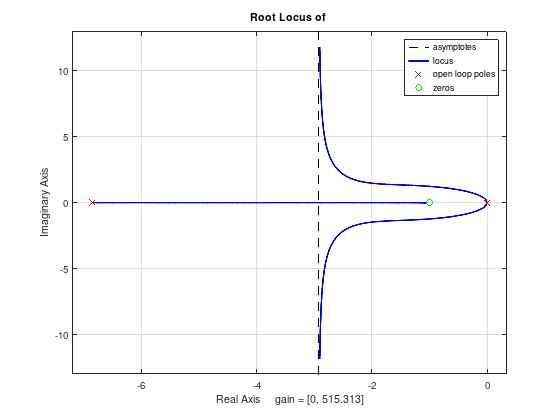

In [8]:
c = tf([1 1],[1]);
FLA*c
rlocus(FLA*c)

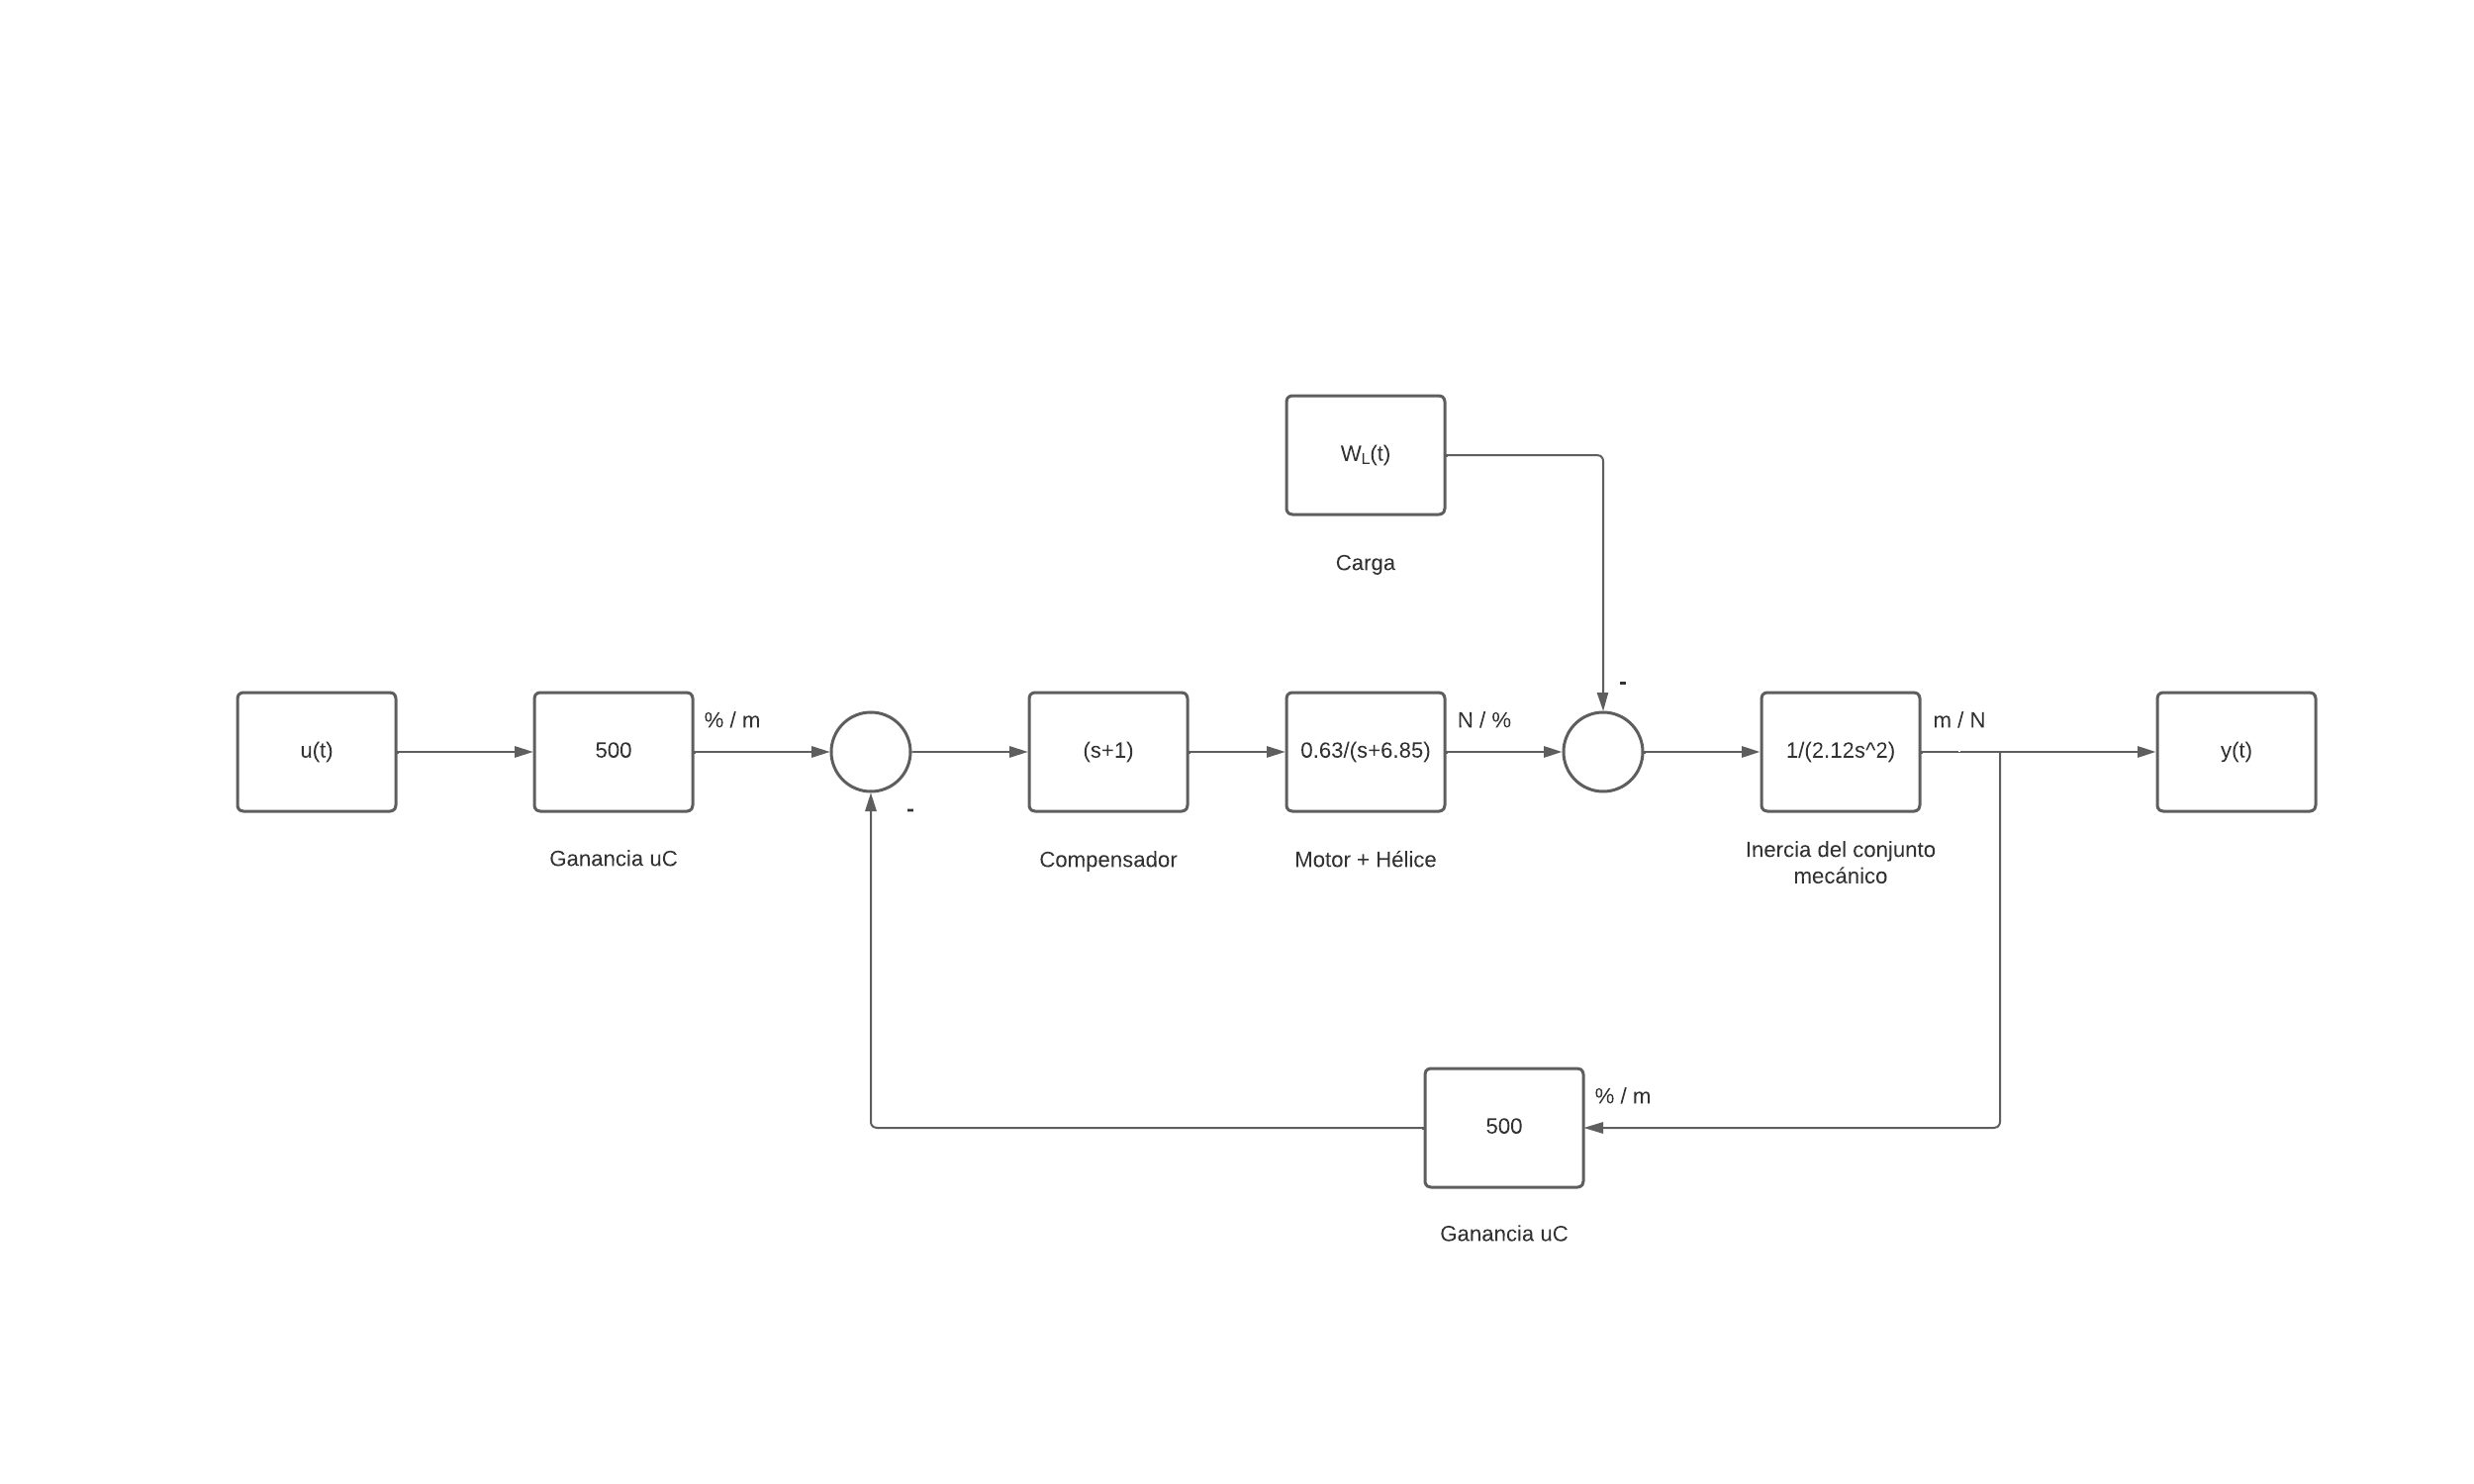


Transfer function 'FLC' from input 'u1' to output ...

                 315 s + 315            
 y1:  ----------------------------------
      2.12 s^3 + 14.52 s^2 + 315 s + 315

Continuous-time model.


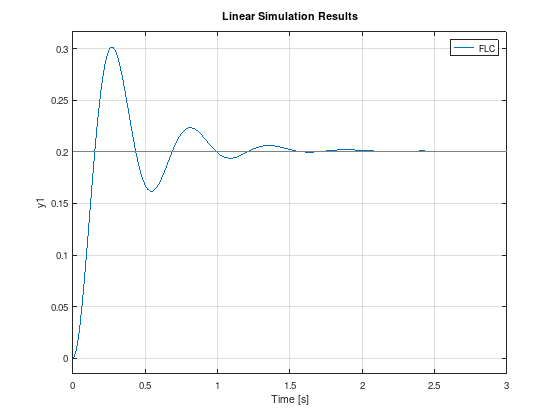

In [9]:
#Entrada del sitema
t = (0:0.01:3)';
step = 0.2*(t>=0);

FLC = ku*feedback(FLA*c,ku)
lsim(FLC, step, t)

El sistema, solo con la introducción de un cero para lograr la estabilización, posee un sobrepaso del 50% y un tiempo de establecimiento aproximado de 2 segundos. **(controlar)**

# Error en régimen permanente
## Tipo de Sistema
El sistema posee dos polos en el origen en la funcion de transferencia de lazo abierto

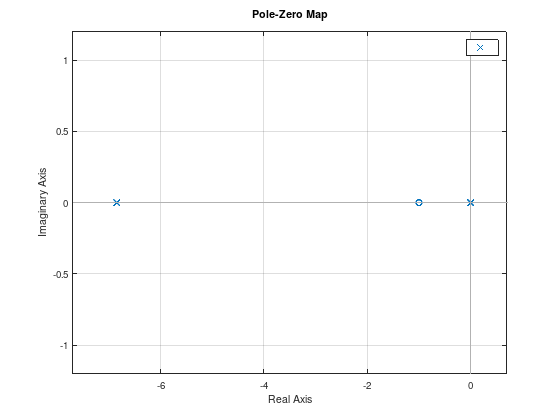

In [10]:
pzmap(FLA*c)

Se puede decir entonces que, el sistema es **tipo 2**. Por lo tanto, no existe error en estado estable para una entrada escalón.

## Análisis de la constante de error de posición 
Se puede analizar el valor de la constante de error de posición para llegar a la misma conclusión, tenemos
$$
K_p = lim_{s\to\infty} G(s)H(s)
$$

Por lo tanto, para el sistema definido por

$$
G(s)*H(s) =  \frac{0.63s + 0.63}{2.12s^3 + 14.52 s^2} * 500 
$$

Tenemos que

$$
K_p = lim_{s\to\infty} \frac{0.63s + 0.63}{2.12s^3 + 14.52 s^2} * 500  = 0
$$

Entonces, el sistema no tiene error de posición para una entrada escalón.



# Diseño del Compensador
Necesitamos compensar el sistema según las especificaciones de diseño establecidas:
- Sobrepaso máximo: 5%
- Tiempo de establecimiento: 1 segundo


$$
M_p = 5\% 
$$

$$
t_s = 1 [s] 
$$

Al no necesitar compensar el error en estado estable, se procederá a utilizar un compensador en adelante para corregir la respuesta transitoria del sistema.

$$
G(s) = \frac{T_s + 1}{T_s + 1/\alpha}
$$

In [11]:
# Calculo de psita
psita = sqrt(1/((-(pi/log(0.03)))^2+1))

psita = 0.7448


In [12]:
# Calculo de omega
omega = 1/psita 

omega = 1.3426


In [13]:
# Punto de operación del sistema
op = -psita*omega + i*omega*sqrt(1-psita^2)

op = -1.0000 + 0.8959i


La función de lazo abierto del sistema, teniendo en cuenta la ganancia del sensor y el cero que estabiliza el sistema está definida como
$$
FdT_{LA} = (s+1) * \frac{0.63}{s+6.85} * \frac{1}{2.12*s^{2}}  * 500
$$

In [14]:
FLA = c*FLA*500


Transfer function 'FLA' from input 'u1' to output ...

          315 s + 315     
 y1:  --------------------
      2.12 s^3 + 14.52 s^2

Continuous-time model.


In [17]:
# Polos y ceros de la función de transferencia
p = pole(FLA)
z = zero(FLA)

p =

  -6.8500
        0
        0

z = -1


Según condición de fase
$$
\sum{\theta_z} - \sum{\theta_p} = \pm 180º(2k+1)
$$

In [22]:
# Calculamos el aporte por los polos en 0
theta_12 = rad2deg(atan((180-atan((omega*sqrt(1-psita^2))/(psita*omega)))))

# Calculamos el aporte
theta_3 = rad2deg(atan((omega*sqrt(1-psita^2))/(-psita*omega-p(1))))

theta_12 = 89.680
theta_3 = 8.7071
